In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('vip_final_churn_score_result_59364_9.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59364 entries, 0 to 59363
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   발급회원번호                    59364 non-null  object 
 1   기준년월                      59364 non-null  int64  
 2   Slope_Spend               59364 non-null  float64
 3   Slope_Balance             59364 non-null  float64
 4   Slope_Count               59364 non-null  float64
 5   Risk_Flag                 59364 non-null  int64  
 6   Churn_Score_Slope         59364 non-null  float64
 7   Churn_Score_Total_Scaled  59364 non-null  float64
 8   Final_Combined_Score      59364 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 4.1+ MB


In [5]:
X = df[['Final_Combined_Score']].values

In [7]:
from sklearn.cluster import KMeans
# 클러스터 개수를 3개로 설정하고 모델 생성 (결과의 일관성을 위해 random_state 고정)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# 모델 학습 및 클러스터 예측 결과 추가
df['Cluster'] = kmeans.fit_predict(X)

# 각 클러스터에 몇 명의 고객이 배정되었는지 확인해볼까?
print(df['Cluster'].value_counts().sort_index())

Cluster
0    49194
1      390
2     9780
Name: count, dtype: int64


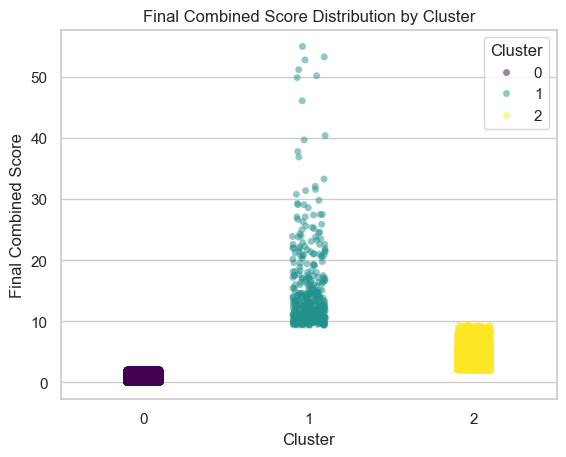

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")

# 클러스터별 점수 분포를 보기 위한 Strip Plot
sns.stripplot(x='Cluster', y='Final_Combined_Score', data=df, hue='Cluster', palette='viridis', jitter=True, alpha=0.5)

# 그래프 제목 및 라벨 설정
plt.title('Final Combined Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Final Combined Score')

# 그래프 저장
# plt.savefig('cluster_distribution.png')

In [9]:
# Cluster 정보를 바탕으로 Target 변수 생성
# 0: 유지(Cluster 0), 1: 이탈 위험(Cluster 1, 2)
df['Target'] = df['Cluster'].map({0: 0, 1: 1, 2: 1})

# 잘 바뀌었는지 상위 데이터만 살짝 확인해볼까?
print(df[['Final_Combined_Score', 'Cluster', 'Target']].head())

   Final_Combined_Score  Cluster  Target
0                   0.1        0       0
1                   2.2        2       1
2                   0.6        0       0
3                   0.4        0       0
4                   0.1        0       0


In [11]:
df['Target'].value_counts()

Target
0    49194
1    10170
Name: count, dtype: int64

In [15]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. 2000개 샘플링 및 X, y 정의
df_sample = df.sample(n=2000, random_state=42)
features = ['Slope_Spend', 'Slope_Balance', 'Slope_Count', 'Risk_Flag', 'Churn_Score_Slope', 'Churn_Score_Total_Scaled']

X = df_sample[features]
y = df_sample['Target']

# 2. VIF 지수 계산
vif_data = pd.DataFrame()
vif_data["Column"] = features
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]

print("VIF 계산이 완료되었어, 상림!")
print(vif_data)

VIF 계산이 완료되었어, 상림!
                     Column       VIF
0               Slope_Spend  1.603867
1             Slope_Balance  1.155377
2               Slope_Count  1.548209
3                 Risk_Flag  1.275833
4         Churn_Score_Slope  2.449814
5  Churn_Score_Total_Scaled  1.221304


In [ ]:
import xgboost as xgb
import shap
import numpy as np

# 1. XGBoost 모델 학습 (이진 분류)
model_xgb = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X, y)

# 2. SHAP Explainer 생성 및 값 계산
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X)

# 3. SHAP 중요도 산출 (평균 절대값)
# XGBoost의 TreeExplainer는 바로 array를 반환하므로 아래와 같이 계산해
shap_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({'Column': features, 'SHAP': shap_importance})

XGBoost 기반 SHAP 계산 완료, 상림!


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:24:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1764148644238/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [17]:
# 1. SHAP 지수와 VIF 지수 결합
# Column명을 기준으로 두 데이터프레임을 합쳐줘
final_report = pd.merge(shap_df, vif_data, on='Column')

# 2. 분석 리포트를 CSV 파일로 저장
final_report.to_csv('feature_analysis_report_xgb.csv', index=False)


print("생성된 파일명: feature_analysis_report_xgb.csv")

# 결과 확인하기
print("\n[최종 분석 결과 테이블]")
print(final_report)

생성된 파일명: feature_analysis_report_xgb.csv

[최종 분석 결과 테이블]
                     Column      SHAP       VIF
0               Slope_Spend  0.000000  1.603867
1             Slope_Balance  0.183719  1.155377
2               Slope_Count  0.000000  1.548209
3                 Risk_Flag  0.000000  1.275833
4         Churn_Score_Slope  5.256438  2.449814
5  Churn_Score_Total_Scaled  0.982265  1.221304
